# Selection for English Premier League Fantasy Football

After signing up to https://fantasy.premierleague.com/ you get to 1) make a team on the first week and 2) transfer players every week. In this simple method, we will only transfer a single player, since it costs points to transfer more than 1 and we will not look into the cost-benefit analysis of that. We are also just going to make the transfer that will give the biggest increase in predicted total score. Note that we do not take into account substitutes, and just pick the cheapest substitutes possible at the beginning and leave them on the bench for the whole season.

### Imports

In [1]:
# %load __init__.py
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pprint import pprint
from scipy.stats import norm, invgamma
from utils import *
from constants import *
from API import *
from ML import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import re

%matplotlib inline

### Last season aggregate statistics

Taken from https://fantasyoverlord.com/FPL/History

### Create team and player summary tables

In [2]:
team_stats = create_team_stats(TEAMS_URL)
player_summary = create_player_summary(PLAYERS_URL, team_stats)
num_players = len(player_summary)
games_df = create_games_data(GAMES_URL,player_summary)

A Jupyter Widget

### Pick full squad
In the first week we want to create the team. We have the total score of each player in their previous year and we have thier cost. Firstly we pick the 4 cheapest substitute players (not given in the code below). Then we pick the most 'efficient' (i.e. best total score to cost ratio) for all the others. This metric is a bit arbitrary, but when I tried in the 2018-19 season it seemed to pick reasonable players (e.g. a mix of high scoring players like Salah, Vardy etc.) and I had a remaining of GBP 5.0 left

'Squad:'
'GKP: Ederson 1.03448275862'
'DEF: Alonso 1.11428571429'
'DEF: Doherty 1.08163265306'
'DEF: Duffy 1.0'
'DEF: Jonny 0.977777777778'
'MID: Fraser 1.04918032787'
'MID: Pereyra 0.890625'
'MID: Gudmundsson 0.816666666667'
'MID: Richarlison 0.811594202899'
'FWD: Wilson 1.02941176471'
'FWD: Jiménez 0.877192982456'
'Median player efficiency (without zeros): 0.36363636363636365'


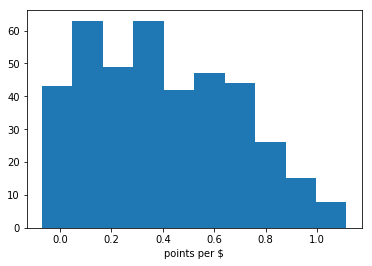

In [18]:
player_summary['efficiency']=player_summary['total_points']/player_summary['now_cost']
player_summary_sorted=player_summary.sort_values(by=['efficiency'],ascending=False)
pprint("Squad:")
for element_type in ELEMENT_TYPE_TO_POSITION.keys():
    position = ELEMENT_TYPE_TO_POSITION[element_type]
    current_players=player_summary_sorted.loc[player_summary_sorted['element_type'] == element_type]
    players=current_players['web_name'][:POSITION_TO_NUMBER[position]]
    for player in players:
        pprint(position + ": " + player + " " + str(current_players.loc[current_players['web_name']==player,'efficiency'].iloc[0]))
pprint('Median player efficiency (without zeros): ' + str(player_summary_sorted.loc[player_summary_sorted['efficiency'] != 0,'efficiency'].median()))
_ = plt.hist(player_summary_sorted.loc[player_summary_sorted['efficiency'] != 0,'efficiency'])
_ = plt.xlabel('points per $')

In [3]:
X,y = make_training_sets(games_df)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

points_cols=list(X_test.filter(regex='total_points'))
regex_cols_to_keep=['total_points','team','was_home']
main_cols=[]
for col in regex_cols_to_keep:
    main_cols = main_cols+(list(X_test.filter(regex=col)))

X_average_test = X_test[points_cols]
y_pred_average = X_average_test.mean(axis=1)

X_weighted_average_train = X_train[points_cols]
X_weighted_average_test = X_test[points_cols]
lm_weighted_average=LinearRegression()
lm_weighted_average.fit(X_weighted_average_train, y_train)
y_pred_weighted_average = lm_weighted_average.predict(X_weighted_average_test)

X_main_train = X_train[main_cols]
X_main_test = X_test[main_cols]

X_main_train = pd.get_dummies(X_main_train)
X_main_test = pd.get_dummies(X_main_test)
for col in list(set(list(X_main_train))-set(list(X_main_test))):
    X_main_test[col] = 0
for col in list(set(list(X_main_test))-set(list(X_main_train))):
    X_main_train[col] = 0

lasso_main = Lasso(alpha=1)
lasso_main.fit(X_main_train, y_train)
y_lasso_pred_main = lasso_main.predict(X_main_test)

rf_main = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_main.fit(X_main_train, y_train)
y_rf_pred_main = rf_main.predict(X_main_test)

X_all_train = X_train
X_all_test = X_test

X_all_train = pd.get_dummies(X_all_train)
X_all_test = pd.get_dummies(X_all_test)
for col in list(set(list(X_all_train))-set(list(X_all_test))):
    X_all_test[col] = 0

lasso_all = Lasso(alpha=1,max_iter=100000)
lasso_all.fit(X_all_train, y_train)
y_lasso_pred_all = lasso_all.predict(X_all_test)

rf_all = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_all.fit(X_all_train, y_train)
y_rf_pred_all = rf_all.predict(X_all_test)

MSE=[]
MSE.append(mean_squared_error(y_true = y_test, y_pred = y_pred_average))
MSE.append(mean_squared_error(y_true = y_test, y_pred = y_pred_weighted_average))
MSE.append(mean_squared_error(y_true = y_test, y_pred = y_pred_main))
MSE.append(mean_squared_error(y_true = y_test, y_pred = y_lasso_pred_main))
MSE.append(mean_squared_error(y_true = y_test, y_pred = y_rf_pred_main))
MSE.append(mean_squared_error(y_true = y_test, y_pred = y_pred_all))
MSE.append(mean_squared_error(y_true = y_test, y_pred = y_lasso_pred_all))
MSE.append(mean_squared_error(y_true = y_test, y_pred = y_rf_pred_all))
MSE

C:\Users\rajkk\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[10.320874999999999,
 10.188546986950826,
 9.8510509610176094,
 10.89595767952169,
 8.5169120749999987,
 78.27893247789099,
 12.258134842769024,
 9.6708132750000004]

In [5]:
gameweek = get_current_gameweek(GAMES_URL)
IDs = games_df['id']
X_pred = games_df
#X_pred = games_df[games_df.columns.drop(list(games_df.filter(regex='_'+str(1))))]
X_pred = X_pred.iloc[:, ~X_pred.columns.str.endswith('_1')]
#renaming trick taken from https://stackoverflow.com/questions/38101009/changing-multiple-column-names-but-not-all-of-them-panda-python
for i in range(2,gameweek+1):
    renaming_cols_dict = dict(zip(games_df.iloc[:,games_df.columns.str.endswith('_'+str(i))], games_df.iloc[:,games_df.columns.str.endswith('_'+str(i-1))]))
    X_pred.rename(columns=renaming_cols_dict,inplace=True)
was_home_new=[]
opponent_team_new=[]
for ID in log_progress(IDs):
    r = requests.get(GAMES_URL+str(ID))
    jsonResponse = r.json()
    was_home_new.append(jsonResponse['fixtures'][0]["is_home"])
    opponent_name = jsonResponse['fixtures'][0]["opponent_name"]
    opponent_team_new.append(team_stats.loc[team_stats["name"]==opponent_name, "team"].item())
next_week_data = pd.DataFrame(data={'id':IDs, 
                                    "was_home_"+str(gameweek-1): was_home_new,
                                    "opponent_team_"+str(gameweek-1): opponent_team_new})
X_pred = X_pred.merge(next_week_data, on="id")
X_pred["was_home_"+str(gameweek-1)] = X_pred["was_home_"+str(gameweek-1)].astype(object)                        
X_pred = X_pred.drop('id',axis=1)

X_pred=X_pred
y_pred = rf_all.predict(pd.get_dummies(X_pred))
player_predictions = pd.DataFrame({'id':np.array(IDs),'prediction_raw':y_pred})
player_summary = player_summary.merge(player_predictions, on='id')
player_summary['prediction']=player_summary['prediction_raw']*player_summary['chance_of_playing_next_round']

C:\Users\rajkk\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


A Jupyter Widget

In [15]:
my_team=my_current_team(GAMES_URL, player_summary)

### Maxed out teams

In [7]:
maxed_out_teams = find_maxed_out_team(my_team, team_stats)

In [8]:
def make_short_list(player_summary):
    ### Picking top players per price ###
    idx = player_summary.groupby(['field_position','now_cost'])['prediction'].transform(max) == player_summary['prediction']
    short_list = player_summary.loc[idx]
    short_list=short_list.loc[short_list['prediction'] != 0]
    return(short_list) 
    
short_list = make_short_list(player_summary)
short_list.loc[short_list['field_position']=='DEF',['second_name','prediction']]

,second_name,prediction
3,Bellerín,2.488
27,Cook,2.286
129,Alonso,5.372
130,Luiz Moreira Marinho,1.765
132,Rüdiger,2.573
163,Wan-Bissaka,2.532
238,Schindler,7.366
239,Löwe,6.397
262,Stankovic,0.694
265,Morgan,4.074


In [16]:
pprint(my_team[['second_name','field_position']])
remaining_cash=1000 - sum(my_team['now_cost'])
my_team = my_team.iloc[[0,1,2,3,4,5,6,7,8,9,10]]

    second_name field_position
0     Fabianski            GKP
1        Stones            DEF
2   Azpilicueta            DEF
3        Alonso            DEF
4     Tarkowski            DEF
5   Milivojevic            MID
6        Fraser            MID
7         Salah            MID
8        Hazard            MID
9      Mitrovic            FWD
10       Agüero            FWD
11      Speroni            GKP
12       Malone            DEF
13     Stephens            MID
14       Quaner            FWD


In [17]:
def find_team_IDs(teams, team_stats):
    team_IDs=[]
    for team in teams:
        team_IDs.append(team_stats.loc[team_stats['name']==team,'team'].max())
    return(team_IDs)
   
def find_best_substitution(short_list,my_team,remaining_cash,maxed_out_teams):    
    #Declare variables
    pred_points=sum(my_team['prediction'])
    max_diff=0
    sub_out=''
    sub_in=''
    maxed_out_team_IDs=find_team_IDs(maxed_out_teams,team_stats)
    #Loop through players and find best transfer
    for cur_idx, cur_player in my_team.iterrows():
        cur_pos=cur_player['field_position']
        cur_cost=cur_player['now_cost']
        cur_pred_points=cur_player['prediction']
        cur_team=cur_player['team']
        #Loop through all players that have same position as current player
        for idx, player in short_list.loc[short_list['field_position']==cur_pos,:].iterrows():
            cost=player['now_cost']
            team_ID=player['team']
            #check if player is already in the team
            if (int(player['id']) not in set(my_team['id'])):
                #Check if proposed player doesn't violate max 3 players per team rule
                if (team_ID not in maxed_out_team_IDs or cur_team==team_ID):
                    #Check if transfer is feasible in terms of money and if proposed player is not already in roster
                    if (cur_cost+remaining_cash-cost>=0):
                        pred_points=player['prediction']
                        #If score differential is more than current maximum, set this transfer as the best one
                        if (pred_points-cur_pred_points > max_diff):
                            sub_out=cur_player['second_name']
                            sub_in=player['second_name']
                            max_diff=pred_points-cur_pred_points
    print('Substitute in ' + sub_in + ' for ' + sub_out+ '.' )
    return(sub_in)

sub_in = find_best_substitution(short_list,my_team[0:11],remaining_cash,maxed_out_teams)
print(my_team[['second_name','prediction']].sort_values('prediction',ascending=False))
print(player_summary[['second_name','prediction']][player_summary['second_name']==sub_in])

Substitute in Chilwell for Tarkowski.
    second_name  prediction
10       Agüero      9.7270
8        Hazard      7.2790
3        Alonso      5.3720
7         Salah      4.1310
9      Mitrovic      3.7200
6        Fraser      3.0740
2   Azpilicueta      2.7650
1        Stones      1.7930
5   Milivojevic      1.5680
0     Fabianski      1.4840
4     Tarkowski      0.3795
    second_name  prediction
269    Chilwell       7.549
